# ELEN4022A - FULL STACK QUANTUM COMPUTING

## CONTRIBUTORS:

### JAMES ALLSOP - 1110612
### MARCO BENVENUTI - 1353626

## GROUP 14 - COLD CALCULATORS


In [62]:
%matplotlib inline

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_textbook.tools import array_to_latex
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector

import numpy as np
import math

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-19 17:50:40,264: Credentials are already in use. The existing account in the session will be replaced.


## Grover's Algorithm

Quantum Computers have the advantage of superior speed with regards to database searching. Using classical computation, there would be an average complexity of $\mathbb{O}(N/2)$ while using quantum algorithms, this complexity reduces to $\sqrt{N}$. This means the quantum algorithm will be vastly superior to classical computing methods when scaled up to real sized data. 

In this part of the exercise, we will explore a 2-qubit N=4 search algorithm, as well as testing the derived circuits.

First, we put all bits in superposition

$| s> = \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle + |11\rangle)$

In [250]:
q_reg = QuantumRegister(2,'q')
c_reg = ClassicalRegister(2,'c')

Next we need to find the Oracle circuits for our search values. These oracle maticies are found 

First, we finding $|11\rangle$ - We then 'mark' $|11\rangle$ by making it negative.

We find our Oracle to be <center>$U_{\omega}|s\rangle = \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle - |11\rangle)$</center>
<br>
Hence:
\begin{equation*}
U_{\omega = 0} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1& 0\\
0 & 0 & 0 & -1
\end{bmatrix}
\end{equation*}
Which is known to be the Unitary matrix for the Controlled Z gate. 

In [ ]:
U3 = QuantumCircuit(q_reg, name='Oracle-11')
######################
## Enter Gates Here ##
######################
U3.draw(output='mpl', plot_barriers=True)

Next we need to find the Oracle circuits for our search values.

First, we finding $|10\rangle$ - We then 'mark' $|10\rangle$ by making it negative.

We find our Oracle to be <center>$U_{\omega}|s\rangle = \frac{1}{2} (|00\rangle + |01\rangle - |10\rangle + |11\rangle)$</center>
<br>
Hence:
\begin{equation*}
U_{\omega = 0} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & -1& 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

This oracle circuit can be realised as follows:

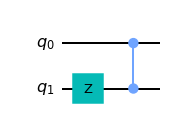

In [253]:
U2 = QuantumCircuit(q_reg, name='Oracle-10')
######################
## Enter Gates Here ##
######################
U2.draw(output='mpl', plot_barriers=True)

Next we need to find the Oracle circuits for our search values.

Finding $|01\rangle$
We find our Oracle to be <center>$U_{\omega}|s\rangle = \frac{1}{2} (|00\rangle - |01\rangle + |10\rangle + |11\rangle)$</center>
<br>
Hence:
\begin{equation*}
U_{\omega = 0} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & 1& 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

Resulting in the Oracle Circuit:

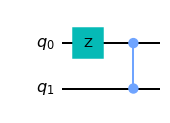

In [254]:
U1 = QuantumCircuit(q_reg, name='Oracle-01')
######################
## Enter Gates Here ##
######################
U1.draw(output='mpl', plot_barriers=True)

Next we need to find the Oracle circuits for our search values.

Finally, we find $|00\rangle$. This will also be used to determine the Difusing circuit.
We find our Oracle to be <center>$U_{\omega}|s\rangle = \frac{1}{2} (|00\rangle - |01\rangle + |10\rangle + |11\rangle)$</center>
<br>
Hence:
\begin{equation*}
U_{\omega = 0} =
\begin{bmatrix}
-1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1& 0\\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}

Resulting in the Oracle Circuit:

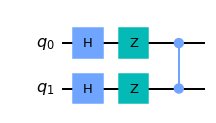

In [284]:
U0 = QuantumCircuit(q_reg, name='Oracle-00')
######################
## Enter Gates Here ##
######################
U0.draw(output='mpl', plot_barriers=True)

$U_{S} = 2|s\rangle\langle s| - \mathbb{1}$
and we know
$H^{\otimes n}|s\rangle = |0\rangle$

We then apply a negative phase change to states orthogonal to $|0\rangle$

So we get $U_{0}\frac{1}{2} (|00\rangle + |01\rangle + |10\rangle + |11\rangle) = \frac{1}{2} (|00\rangle - |01\rangle - |10\rangle - |11\rangle) $


\begin{equation*}
U_{0} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & -1
\end{bmatrix}
\end{equation*}

This can be reaslised as a circiut as below:

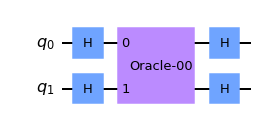

In [285]:
US = QuantumCircuit(q_reg, name='Diffuser')
US.h(q_reg)
US.append(U0.to_gate(), q_reg)
US.h(q_reg)
US.draw(output='mpl', plot_barriers=True)

In [268]:
from qiskit.providers.aer.noise import NoiseModel

backend = provider.get_backend('ibmq_16_melbourne')
qasmsim = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

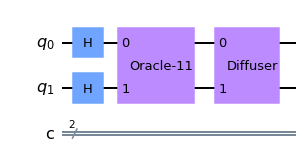

In [286]:
qc = QuantumCircuit(q_reg, c_reg)
qc.h(q_reg)
qc.append(U3.to_gate(),q_reg)
qc.append(US.to_gate(),q_reg)
qc.draw(output='mpl', plot_barriers=True)

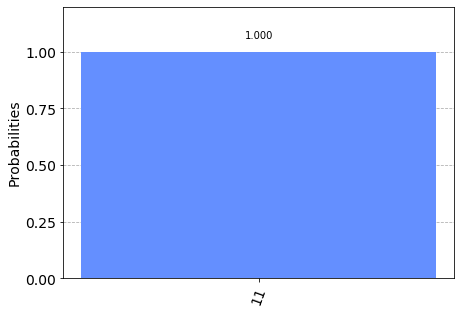

In [287]:
qc.measure(q_reg, c_reg)
backend = provider.get_backend('ibmq_qasm_simulator')
transpiled = transpile(qc, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())
counts = retrieved_job.result().get_counts()
plot_histogram(counts)

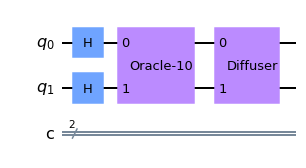

In [288]:
qc = QuantumCircuit(q_reg, c_reg)
qc.h(q_reg)
qc.append(U2.to_gate(),q_reg)
qc.append(US.to_gate(),q_reg)
qc.draw(output='mpl', plot_barriers=True)

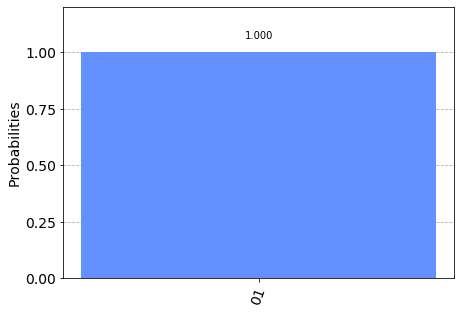

In [289]:
qc.measure(q_reg, c_reg)
backend = provider.get_backend('ibmq_qasm_simulator')
transpiled = transpile(qc, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())
counts = retrieved_job.result().get_counts()
plot_histogram(counts)

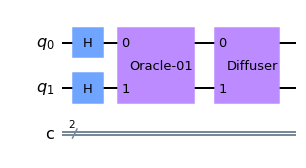

In [290]:
qc = QuantumCircuit(q_reg, c_reg)
qc.h(q_reg)
qc.append(U1.to_gate(),q_reg)
qc.append(US.to_gate(),q_reg)
qc.draw(output='mpl', plot_barriers=True)

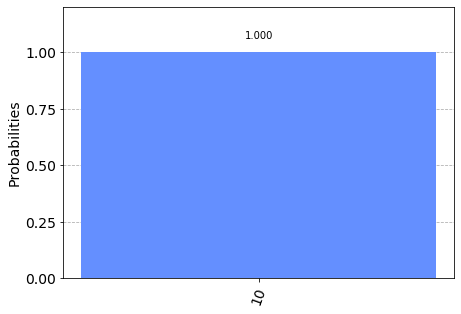

In [291]:
qc.measure(q_reg, c_reg)
backend = provider.get_backend('ibmq_qasm_simulator')
transpiled = transpile(qc, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())
counts = retrieved_job.result().get_counts()
plot_histogram(counts)

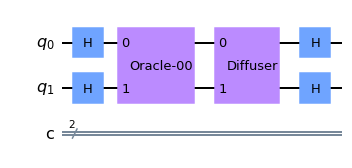

In [303]:
qc = QuantumCircuit(q_reg, c_reg)
qc.h(q_reg)
qc.append(U0.to_gate(),q_reg)
qc.append(US.to_gate(),q_reg)
qc.h(q_reg)
qc.draw(output='mpl', plot_barriers=True)

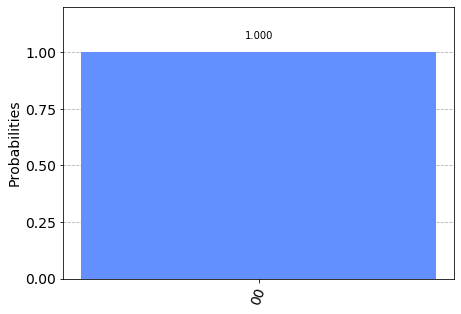

In [304]:
qc.measure(q_reg, c_reg)
backend = provider.get_backend('ibmq_qasm_simulator')
transpiled = transpile(qc, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())
counts = retrieved_job.result().get_counts()
plot_histogram(counts)